<img src="logo_fifa.png" width="400">
# Taller numérico/instrumental de Python  
## Temario
* Simulación de ODE (de primer orden) [Proximamente, de orden superior!)
* Análisis de datos
 - Transformación de datos, filtrado
 - Ajuste de modelos
 - Integración
 - Derivación
* Adquisición de datos
* Gráficos

Importamos librerías para el uso posterior

In [1]:
import io
import time
import serial
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
from serial.tools import list_ports
import scipy as sp
import scipy.optimize as opt
%matplotlib inline

#Estilos de los gráficos de matplotlib.
plt.rcParams["figure.figsize"] = (5 * (1 + np.sqrt(5)) / 2, 5)
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.grid"] = True

## Simulación del circuito
En este taller vamos a analizar el siguiente circuito, que corresponde a un RC

<img src="rc.png" width="400">

Para encontrar la tensión en el capacitor usamos la segunda ley de Kirchoff, que nos dice que

$v_{in} = v_{R} + v_{c}$  
$ v_{in}(t) = R\;i(t) + \frac{1}{C} \int_{0}^{t} i(\tau) d\tau $

que si derivamos respecto al tiempo y multiplicamos por $C$, finalmente llegamos a la ecuación diferencial

$$ RC \; \frac{d i(t)}{dt} + i(t) = C \frac{d v_{in}(t)}{dt} $$

Para una señal escalón, que se simula con una señal cuadrada, se puede demostrar (ver https://en.wikipedia.org/wiki/Heaviside_step_function) que la derivada es nula para $t>0$, que es el tiempo que nos importa, por lo que vamos a resolver finalmente la siguiente ecuación 

$$ RC \; \frac{d i(t)}{dt} + i(t) = 0 $$
$$\frac{d i(t)}{dt} = - \frac{1}{RC} i(t)$$
Pasemos a la simulación propiamente dicha, para lo que definimos el parámetro
$$\tau = RC$$

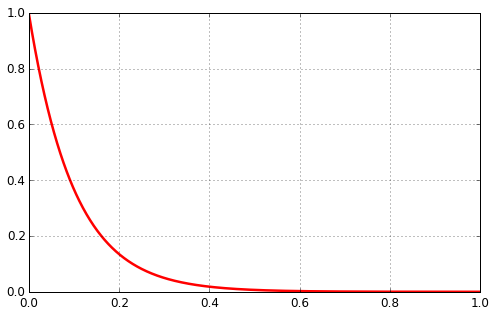

In [2]:
tau = 10 #Varien el parámetro y vean el resultado
def f(y, t, tau):
    return (-y * tau) 
t = np.linspace(0, 1, 1000)
y0 = [1]
y = sp.integrate.odeint(f, y0, t, args = (tau,))
plt.plot(t, y, 'r-');

Recordemos que la ecuación diferencial que estamos resolviendo corresponde a la corriente del circuito. Si en vez de eso queremos la tensión del capacitor, debemos integrar este resultado, ya que

$$ v_{c}(t) = \frac{1}{C} \int_{0}^{t} i(\tau) d\tau $$

Con la librería _scipy.integrate_, y la función _cumtrapz_, podemos integrar, ya que permite aplicar acumulativamente la regla del trapesoide.

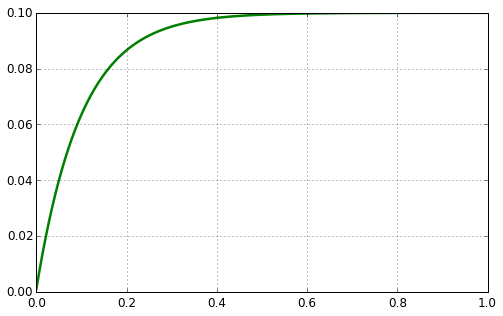

In [3]:
y_int = sp.integrate.cumtrapz(y.ravel(), t)
plt.plot(t[:-1], y_int.ravel(),'g-')

## Adquisición de datos
Acá están las funciones para adquisición de datos. **No es necesario ejecutarlas**, pero si tenés un dispositivo serie que devuelva una lista de datos ASCII separada por tabulaciones (como ser algunos osciloscopios, por ejemplo), esto te va a permitir guardarlo!. Mientras, está pensado para utilizarlo con un [Arduino](http://www.arduino.cc), que fue programado por nosotros (y [acá está el código]() en Processing para ver que se hace). La librería _pandas_ tiene herramientas muy poderosas de análisis y filtrado de datos, pero es más de lo que necesitamos en general y usamos solamente _numpy_

In [4]:
def inputPort():
    '''Obtiene la lista de puertos, la presenta en pantalla y da 
    a elegir un puerto, devolviendo el string para conectarse
    '''
    ports = list(list_ports.comports())
    for i,p in enumerate(ports):
        print("[{}]: Puerto {}".format(i + 1, p[1]))
    port = ""
    if len(ports) > 0:
        port = ports[int(input("Ingrese el puerto serie: ")) - 1][0]
    return port

def updateData(s):
    '''Obtiene los datos que manda el Arduino/Teensy por UART USB'''
    A = []
    s.flushInput()
    s.write(b"1")
    time.sleep(2)
    while True:
        if ser.inWaiting() == 0:
            break
        A.append(s.read().decode())
    A = "".join(A)
    data = pd.read_csv(io.StringIO(A),sep="\t",names=["t","v"])
    data = data.convert_objects(convert_numeric = True)
    return data

port = inputPort()
ser = serial.Serial(port, "9600")
data = updateData(ser).values
ser.close()
np.savetxt("data.csv", data)

[1]: Puerto USB Serial Device (COM5)
Ingrese el puerto serie: 1


## Análisis de datos
Adquiridos datos o ya adquiridos, vamos a analizarlos.

In [5]:
data = np.loadtxt("RC.csv")  #Traigo datos ya adquiridos

In [5]:
print(type(data))
#print(dir(data))  #Permite graficar las funciones del ndarray
print(data)

<class 'numpy.ndarray'>
[[  8.00000000e+00   2.50000000e+01]
 [  1.32000000e+02   1.39000000e+02]
 [  2.48000000e+02   2.40000000e+02]
 [  3.68000000e+02   3.29000000e+02]
 [  4.88000000e+02   4.08000000e+02]
 [  6.08000000e+02   4.78000000e+02]
 [  7.28000000e+02   5.40000000e+02]
 [  8.48000000e+02   5.95000000e+02]
 [  9.68000000e+02   6.44000000e+02]
 [  1.08800000e+03   6.87000000e+02]
 [  1.20800000e+03   7.25000000e+02]
 [  1.32800000e+03   7.59000000e+02]
 [  1.44800000e+03   7.89000000e+02]
 [  1.56800000e+03   8.16000000e+02]
 [  1.68800000e+03   8.39000000e+02]
 [  1.80800000e+03   8.60000000e+02]
 [  1.92800000e+03   8.79000000e+02]
 [  2.04800000e+03   8.95000000e+02]
 [  2.16800000e+03   9.10000000e+02]
 [  2.28800000e+03   9.23000000e+02]
 [  2.40800000e+03   9.34000000e+02]
 [  2.52800000e+03   9.44000000e+02]
 [  2.64800000e+03   9.53000000e+02]
 [  2.76800000e+03   9.61000000e+02]
 [  2.88800000e+03   9.68000000e+02]
 [  3.00800000e+03   9.74000000e+02]
 [  3.12800000

Ahora imprimimos los datos. Como son dos tiras de datos, debemos imprimir varios

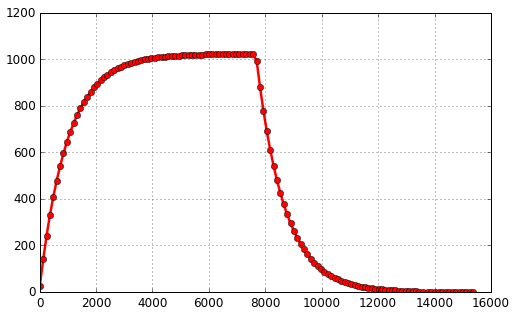

In [6]:
plt.plot(data[:,0], data[:,1], "ro-");

Vamos a hacer un poco de análisis de datos, para eso, tomemos solamente una parte de la curva verde. Index slicing al rescate! Graficamos para revistar los resultados

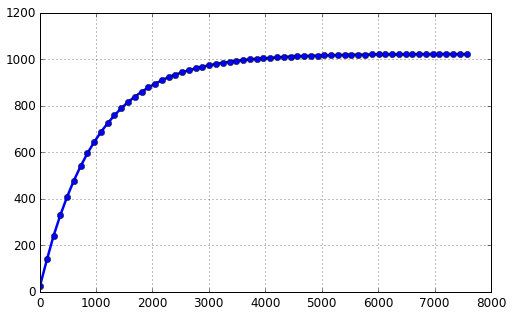

In [7]:
fitData = data[0:64]
plt.plot(fitData[:,0], fitData[:,1], 'bo-')

Para ajustar el modelo, que sabemos que es  
$ V = V_0 ( 1 - e^{-B t}) $  
primero construimos la función

In [8]:
f = lambda x, A, B, C: A * (1 - np.exp(- B * x)) + C

Y luego usamos la función curve_fit de scipy

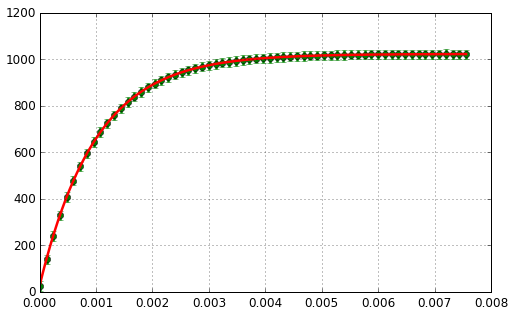

In [9]:
T = (fitData[:,0] - fitData[:,0].min()) * 1e-6
V = fitData[:,1]
ErrV = 20  #Este error corresponde solamente al instrumental
p, cov = opt.curve_fit(f, T, V)
#Construyo una variable auxiliar del T
t = np.linspace(T.min(), T.max(), 1000)
plt.errorbar(T, V, yerr = ErrV, fmt = 'go')
#plt.plot(T, V, 'go')
plt.plot(t, f(t, *p), 'r-') #Grafico el ajuste

La función curve_fit no devuelve el $\chi$-cuadrado, pero podemos calcularlo rápidamente

In [10]:
chi2Red = (np.power((V - f(T, *p)) / np.sqrt(ErrV), 2)).sum()/(len(V) - 2)
chi2Red

0.013124833016893487

Acá tenemos el $\chi$-cuadrado reducido, que debe ser cercano a 1. Si es mucho menor que 1, los errores están sobre dimensionados; si es mucho mayor a 1, el ajuste puede ser rechazado. Para cuantificar la palabra "mucho" podemos usar el p-valor con el test de $\chi$-cuadrado (https://en.wikipedia.org/wiki/Goodness_of_fit)

## Derivación e integración

Ahora vamos a tomar datos para un integrador y un derivador. Para eso ejecuten la parte de adquisición de datos, si tienen el dispositivo, y obtengan los datos. Si no importenlos como ya hicimos

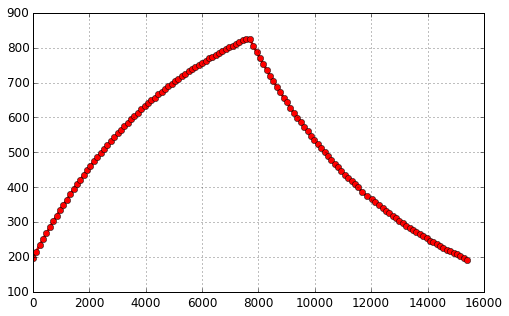

In [11]:
data = np.loadtxt("RC_int.csv")
plt.plot(data[:,0], data[:,1], "ro-");

Derivemos los datos para ver que resultado tenemos. Para eso tenemos la función de _numpy.diff_. Notar que al diferenciar el resultado tiene un dato menos, por lo que se debe eliminar del "vector tiempo" data[:,0] 

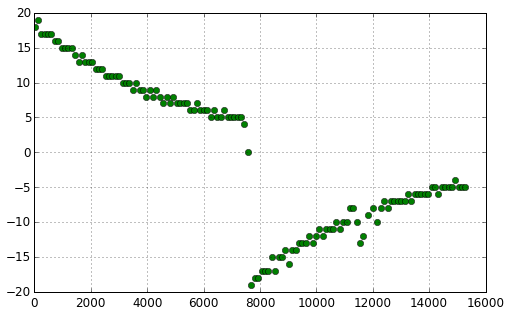

In [12]:
plt.plot(data[:-1,0], np.diff(data[:,1]), 'go');

Se "parece" a una cuadrada, creemos datos que representen a una cuadrada e integremoslos y comparandolos. Para eso, debemos usar la función _scipy.integrate.cumtrapz_. Luego reescalamos la señal integrada para compararla con la cuadrada

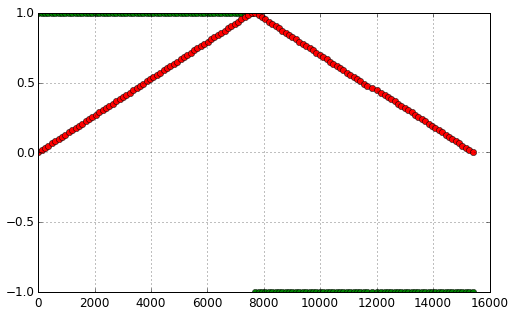

In [13]:
T = data[:,0]
N = int(data[:,1].shape[0] / 2)
V = np.concatenate((np.full(N, 1), np.zeros(N) - 1))
plt.plot(T,V,'go')
V_int = sp.integrate.cumtrapz(V, initial = 0)
V_int /= V_int.max()
plt.plot(T, V_int, 'ro')

Veamos ahora comparado los datos adquiridos respecto a la integración numérica, escalado para que sea comparable

[<matplotlib.lines.Line2D at 0xe9a470>, <matplotlib.lines.Line2D at 0xe9a780>]

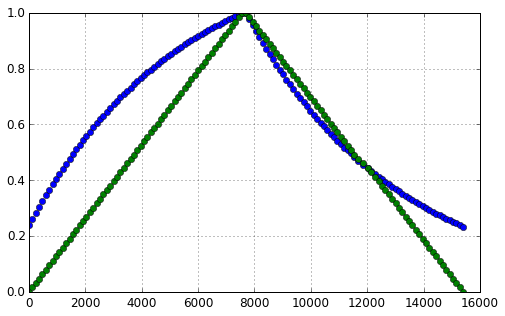

In [14]:
plt.plot(data[:,0], data[:,1] / data[:,1].max(), 'bo', T, V_int, 'go')

Se nota que el circuito RC se acerca a la integración numérica, pero debido a lo que se conoce como ganancia del filtro RC y la constante de tiempo $\tau$ no se llega a obtener un integrador real. Para mejorar esto, en general, se debe usar circuitos activos (ver https://en.wikipedia.org/wiki/Active_filter), pero requieren más experiencia de diseño